In [ ]:
# Mobile Price Regression & Banknote Classification


In [1]:
# 1. Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.mplot3d import Axes3D

RND = 42
np.random.seed(RND)


In [ ]:
## Part A — Regression (Mobile Phone Price Prediction)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd, os
mobile_path = "/content/drive/MyDrive/train (1).csv"

if not os.path.exists(mobile_path):
    raise FileNotFoundError(f"File not found at {mobile_path}. Check your path and name.")

df = pd.read_csv(mobile_path)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


Shape: (2000, 21)

Data types:
 battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object

Missing values per column:
 battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
d

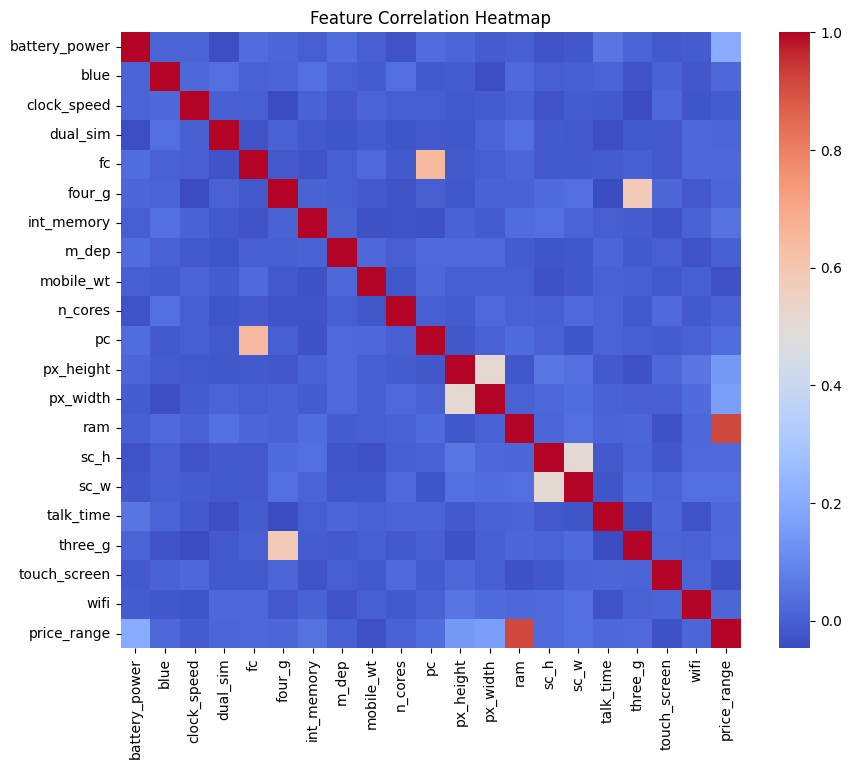

In [7]:
# 3. Basic EDA
print("Shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nSummary statistics:\n", df.describe())

# Check target balance
print("\nTarget value counts:\n", df['price_range'].value_counts())

# Correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


In [8]:
# 4. Handle missing values if any
df = df.fillna(df.mean(numeric_only=True))


In [9]:
# 5. Outlier treatment
num_cols = df.select_dtypes(include=['int64','float64']).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    df[col] = df[col].clip(lower, upper)
print("Outliers capped using IQR method.")


Outliers capped using IQR method.


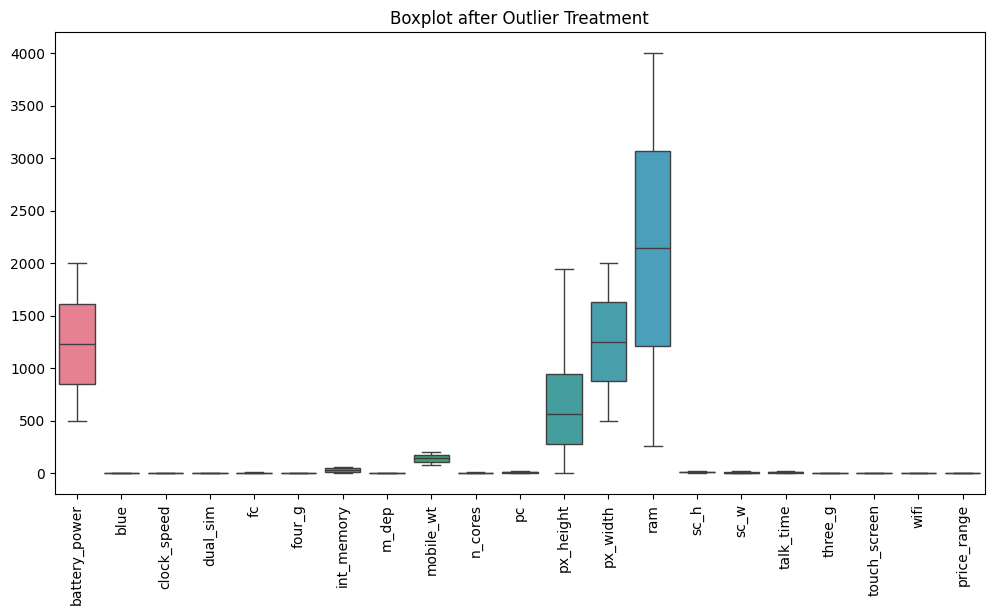

In [10]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[num_cols])
plt.xticks(rotation=90)
plt.title("Boxplot after Outlier Treatment")
plt.show()


In [11]:
# Split into X, y
X = df.drop('price_range', axis=1)
y = df['price_range']


In [12]:
# 3. Prepare X, y (treat price_range as numeric target)
target = 'price_range'
features = [c for c in df.columns if c != target]
X_all = df[features].values.astype(float)
y_all = df[target].values.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=RND)


In [13]:
# 4. Utilities: bias, closed-form, gradient descent, predict
def add_bias(X):
    return np.hstack([np.ones((X.shape[0],1)), X])

def closed_form(X, y, l2=0.0):
    nF = X.shape[1]
    I = np.eye(nF); I[0,0]=0.0
    A = X.T @ X + l2 * I
    return np.linalg.pinv(A) @ (X.T @ y)

def gradient_descent(X, y, lr=1e-3, epochs=5000, l2=0.0):
    n, d = X.shape
    w = np.zeros(d)
    for _ in range(epochs):
        pred = X @ w
        grad = (2.0/n) * (X.T @ (pred - y)) + 2.0 * l2 * np.r_[0.0, w[1:]]
        w -= lr * grad
    return w

def evaluate(y_true, y_pred):
    return mean_squared_error(y_true, y_pred), r2_score(y_true, y_pred)


In [14]:

# Split features and target
X = df.drop('price_range', axis=1).values
y = df['price_range'].values

# Add bias and split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_b = add_bias(X_train)
X_test_b  = add_bias(X_test)


In [15]:
w_closed = closed_form(X_train_b, y_train)
y_pred_closed = X_test_b @ w_closed

mse_c, r2_c = evaluate(y_test, y_pred_closed)
print("Closed-form: MSE =", mse_c, "R2 =", r2_c)


Closed-form: MSE = 0.10472284807318065 R2 = 0.9215114569034476


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Add bias
X_train_s_b = add_bias(X_train_s)
X_test_s_b  = add_bias(X_test_s)


In [19]:
# --- Standardize data before using Gradient Descent ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

X_train_s_b = add_bias(X_train_s)
X_test_s_b  = add_bias(X_test_s)

# --- Gradient Descent on Standardized Data ---
w_gd = gradient_descent(X_train_s_b, y_train, lr=1e-3, epochs=3000)
y_pred_gd = X_test_s_b @ w_gd

mse_gd, r2_gd = evaluate(y_test, y_pred_gd)
print("Gradient Descent (standardized): MSE =", mse_gd, "R2 =", r2_gd)


Gradient Descent (standardized): MSE = 0.10476302848903245 R2 = 0.9214813421542859


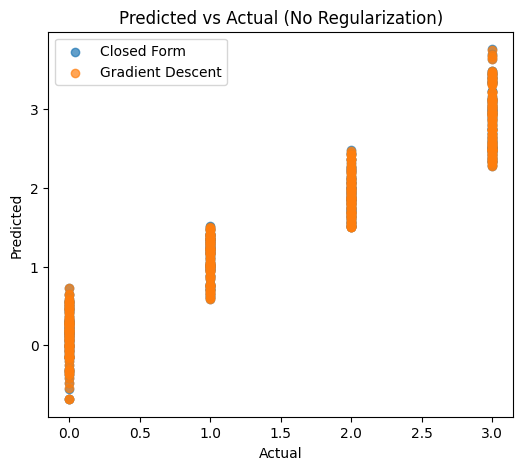

In [20]:
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_closed, label='Closed Form', alpha=0.7)
plt.scatter(y_test, y_pred_gd, label='Gradient Descent', alpha=0.7)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (No Regularization)")
plt.legend()
plt.show()


In [22]:
# --- Standardize data first ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

X_train_s_b = add_bias(X_train_s)
X_test_s_b  = add_bias(X_test_s)

# --- L2 Regularization ---
l2_val = 10

# Closed-form ridge regression
w_closed_l2 = closed_form(X_train_s_b, y_train, l2=l2_val)

# Gradient descent ridge regression
w_gd_l2 = gradient_descent(X_train_s_b, y_train, lr=1e-3, epochs=3000, l2=l2_val)

# Predictions
y_pred_closed_l2 = X_test_s_b @ w_closed_l2
y_pred_gd_l2 = X_test_s_b @ w_gd_l2

# Evaluation
mse_c_l2, r2_c_l2 = evaluate(y_test, y_pred_closed_l2)
mse_gd_l2, r2_gd_l2 = evaluate(y_test, y_pred_gd_l2)

print(f"Closed-form Ridge (λ={l2_val}): MSE={mse_c_l2:.4f}, R2={r2_c_l2:.4f}")
print(f"Gradient Descent Ridge (λ={l2_val}): MSE={mse_gd_l2:.4f}, R2={r2_gd_l2:.4f}")


Closed-form Ridge (λ=10): MSE=0.1049, R2=0.9214
Gradient Descent Ridge (λ=10): MSE=1.1229, R2=0.1584


In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
X_train_s_b = add_bias(X_train_s)
X_test_s_b  = add_bias(X_test_s)

w_closed_std = closed_form(X_train_s_b, y_train, l2=10)
y_pred_std = X_test_s_b @ w_closed_std

mse_std, r2_std = evaluate(y_test, y_pred_std)
print("Standardized Ridge: MSE =", mse_std, "R2 =", r2_std)


Standardized Ridge: MSE = 0.10490889900347188 R2 = 0.9213720139191419


In [24]:
# --- Without Standardization ---
X_train_b = add_bias(X_train)
X_test_b  = add_bias(X_test)
w_closed_nstd = closed_form(X_train_b, y_train, l2=10)
y_pred_nstd = X_test_b @ w_closed_nstd
mse_nstd, r2_nstd = evaluate(y_test, y_pred_nstd)

# --- With Standardization (you already have these) ---
mse_std, r2_std = evaluate(y_test, y_pred_std)

# --- Print Comparison ---
print("Ridge Regression Comparison (λ=10)")
print(f"Without Standardization → MSE: {mse_nstd:.4f}, R2: {r2_nstd:.4f}")
print(f"With Standardization    → MSE: {mse_std:.4f}, R2: {r2_std:.4f}")


Ridge Regression Comparison (λ=10)
Without Standardization → MSE: 0.1047, R2: 0.9215
With Standardization    → MSE: 0.1049, R2: 0.9214


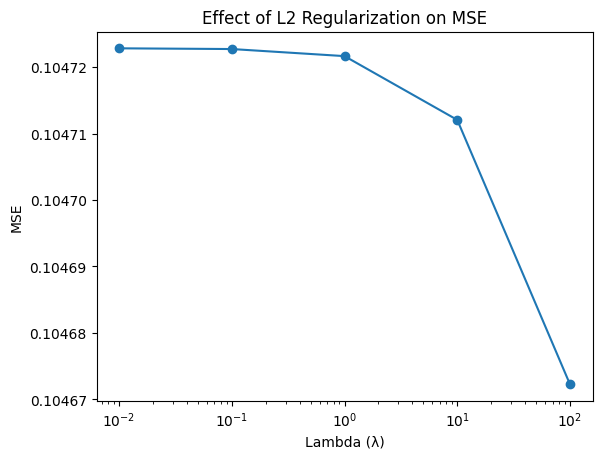

In [25]:
lambdas = [0.01, 0.1, 1, 10, 100]
mse_list = []

for lam in lambdas:
    w = closed_form(X_train_b, y_train, l2=lam)
    y_pred = X_test_b @ w
    mse, _ = evaluate(y_test, y_pred)
    mse_list.append(mse)

plt.plot(lambdas, mse_list, marker='o')
plt.xscale('log')
plt.xlabel("Lambda (λ)")
plt.ylabel("MSE")
plt.title("Effect of L2 Regularization on MSE")
plt.show()


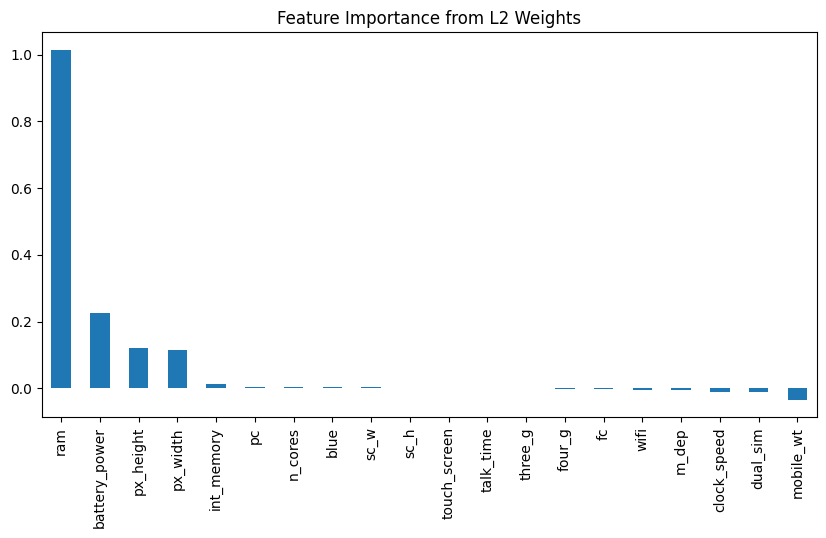

In [26]:
import pandas as pd
feature_names = df.drop('price_range', axis=1).columns
weights = pd.Series(w_closed_l2[1:], index=feature_names)
weights.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("Feature Importance from L2 Weights")
plt.show()


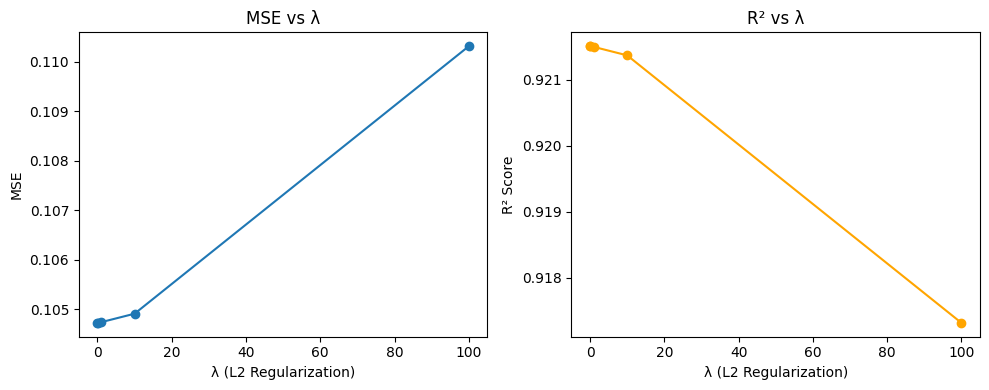

In [27]:
import matplotlib.pyplot as plt

lambdas = [0, 0.1, 1, 10, 100]
mse_list, r2_list = [], []

for l2_val in lambdas:
    w_ridge = closed_form(X_train_s_b, y_train, l2=l2_val)
    y_pred = X_test_s_b @ w_ridge
    mse, r2 = evaluate(y_test, y_pred)
    mse_list.append(mse)
    r2_list.append(r2)

# --- Plot MSE and R2 for different λ values ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lambdas, mse_list, marker='o')
plt.title("MSE vs λ")
plt.xlabel("λ (L2 Regularization)")
plt.ylabel("MSE")

plt.subplot(1,2,2)
plt.plot(lambdas, r2_list, marker='o', color='orange')
plt.title("R² vs λ")
plt.xlabel("λ (L2 Regularization)")
plt.ylabel("R² Score")
plt.tight_layout()
plt.show()


Top 10 Most Important Features:


,Feature,Weight,AbsWeight
13,ram,1.014731,1.014731
0,battery_power,0.224869,0.224869
11,px_height,0.120784,0.120784
12,px_width,0.116055,0.116055
8,mobile_wt,-0.034209,0.034209
6,int_memory,0.012651,0.012651
3,dual_sim,-0.012108,0.012108
2,clock_speed,-0.009493,0.009493
7,m_dep,-0.005605,0.005605
10,pc,0.005130,0.005130


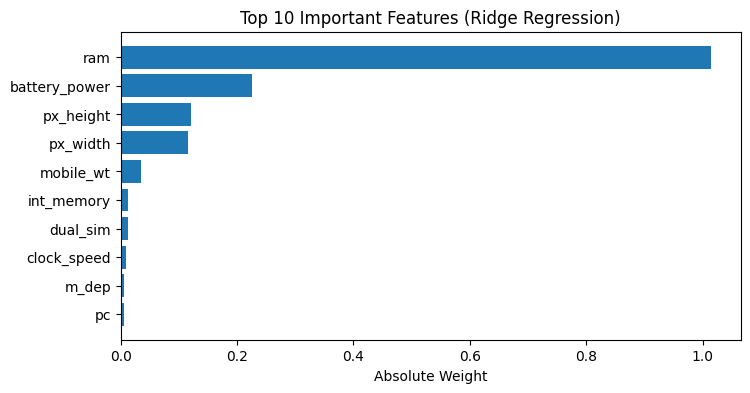

In [29]:
# --- Feature importance (Fixed) ---

# Use original feature names from the DataFrame
feature_names = df.drop("price_range", axis=1).columns
weights = w_closed_std[1:]   # exclude bias

# Sort by absolute importance
importance = pd.DataFrame({
    "Feature": feature_names,
    "Weight": weights,
    "AbsWeight": np.abs(weights)
}).sort_values(by="AbsWeight", ascending=False)

print("Top 10 Most Important Features:")
display(importance.head(10))

# --- Visualization ---
plt.figure(figsize=(8,4))
plt.barh(importance["Feature"].head(10), importance["AbsWeight"].head(10))
plt.gca().invert_yaxis()
plt.title("Top 10 Important Features (Ridge Regression)")
plt.xlabel("Absolute Weight")
plt.show()


#Task 2

In [32]:
import pandas as pd
import os

# Correct path
bank_path = "/content/drive/MyDrive/data_banknote_authentication.txt"

if not os.path.exists(bank_path):
    raise FileNotFoundError(f"File not found at {bank_path}")

# Load CSV-formatted .txt file
bank_df = pd.read_csv(bank_path, header=None)
bank_df.columns = ["variance", "skewness", "curtosis", "entropy", "class"]

print("Dataset loaded:", bank_df.shape)
bank_df.head()


Dataset loaded: (1372, 5)


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB
None

Missing Values per Column:
variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

Summary Statistics:
          variance     skewness     curtosis      entropy        class
count  1372.000000  1372.000000  1372.000000  1372.000000  1372.000000
mean      0.433735     1.922353     1.397627    -1.191657     0.444606
std       2.842763     5.869047     4.310030     2.101013     0.497103
min      -7.042100   -13.773100    -5.286100    -8.548200     0.000000
25%      -1.773000    -1.708200    -1.574975    -2.413450     0

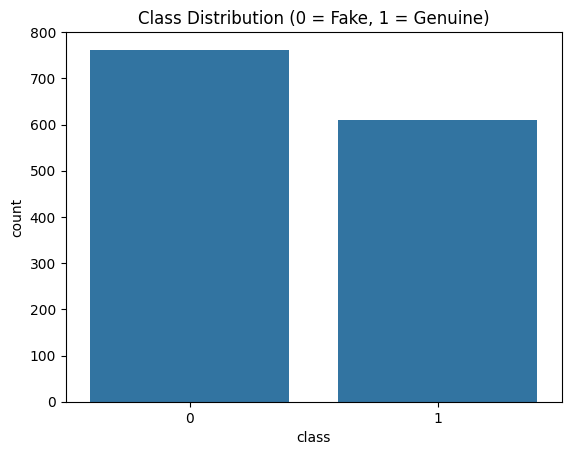

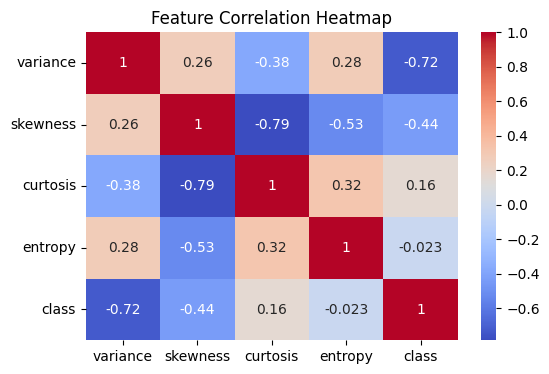

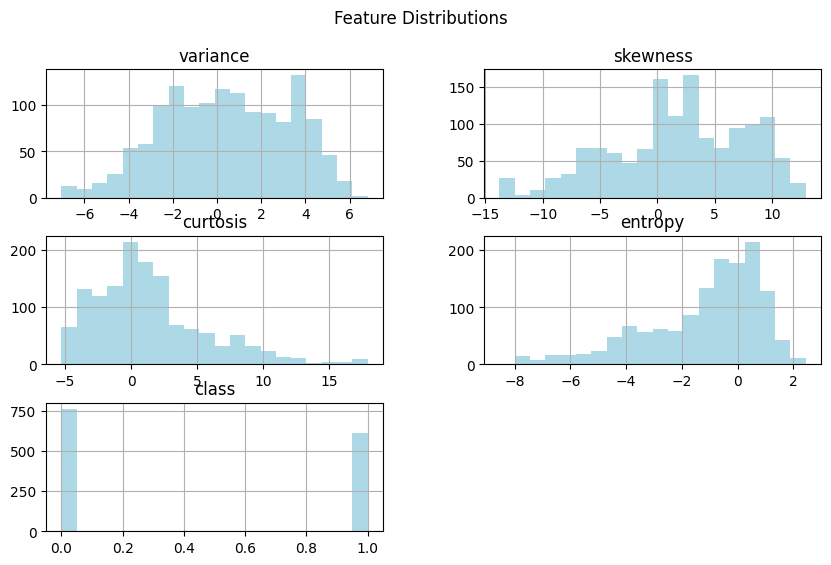

In [33]:
# Basic info
print("\nDataset Info:")
print(bank_df.info())

# Check for missing values
print("\nMissing Values per Column:")
print(bank_df.isnull().sum())

# Handle missing values
bank_df = bank_df.dropna()

# Basic statistics
print("\nSummary Statistics:")
print(bank_df.describe())

# Class distribution
sns.countplot(x="class", data=bank_df)
plt.title("Class Distribution (0 = Fake, 1 = Genuine)")
plt.show()

# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(bank_df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Feature distributions
bank_df.hist(figsize=(10,6), bins=20, color='lightblue')
plt.suptitle("Feature Distributions")
plt.show()


In [34]:
# Outlier detection using IQR
Q1 = bank_df.quantile(0.25)
Q3 = bank_df.quantile(0.75)
IQR = Q3 - Q1

# Filter out extreme outliers (optional)
bank_df_clean = bank_df[~((bank_df < (Q1 - 1.5 * IQR)) | (bank_df > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Original shape: {bank_df.shape}, After removing outliers: {bank_df_clean.shape}")


Original shape: (1372, 5), After removing outliers: (1280, 5)


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Xb = bank_df_clean.drop("class", axis=1).values
yb = bank_df_clean["class"].values

Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, random_state=42)

scaler_b = StandardScaler()
Xb_train_s = scaler_b.fit_transform(Xb_train)
Xb_test_s = scaler_b.transform(Xb_test)

def add_bias(X):
    return np.hstack([np.ones((X.shape[0],1)), X])

Xb_train_s_b = add_bias(Xb_train_s)
Xb_test_s_b  = add_bias(Xb_test_s)


In [37]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_loss_grad(X, y, w, l2=0.0):
    n = X.shape[0]
    y_pred = sigmoid(X @ w)
    grad = (1/n) * (X.T @ (y_pred - y)) + 2*l2*np.r_[0, w[1:]]
    return grad

def logistic_regression(X, y, lr=0.1, epochs=5000, l2=0.0):
    w = np.zeros(X.shape[1])
    for _ in range(epochs):
        w -= lr * logistic_loss_grad(X, y, w, l2)
    return w

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


In [38]:
# Without L2
w_plain = logistic_regression(Xb_train_s_b, yb_train, lr=0.1, epochs=5000, l2=0)
y_pred_plain = (sigmoid(Xb_test_s_b @ w_plain) >= 0.5).astype(int)
acc_plain = accuracy(yb_test, y_pred_plain)

# With L2 regularization
w_ridge = logistic_regression(Xb_train_s_b, yb_train, lr=0.1, epochs=5000, l2=0.1)
y_pred_ridge = (sigmoid(Xb_test_s_b @ w_ridge) >= 0.5).astype(int)
acc_ridge = accuracy(yb_test, y_pred_ridge)

print(f"Without L2:  Test Accuracy = {acc_plain:.4f}")
print(f"With L2=0.1: Test Accuracy = {acc_ridge:.4f}")


Without L2:  Test Accuracy = 0.9766
With L2=0.1: Test Accuracy = 0.9375


/tmp/ipython-input-2431069985.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


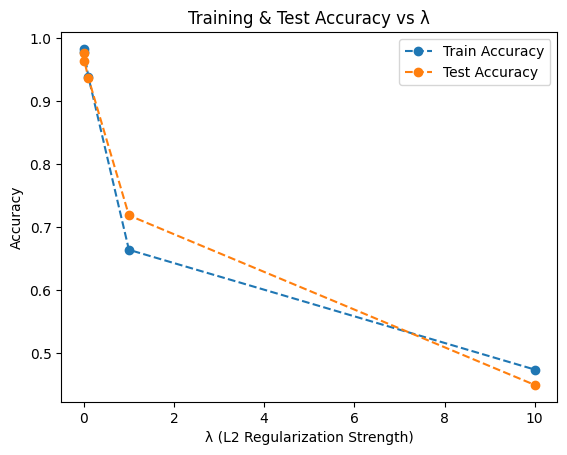

In [39]:
lambdas = [0, 0.01, 0.1, 1, 10]
accs_train, accs_test = [], []

for l2_val in lambdas:
    w_tmp = logistic_regression(Xb_train_s_b, yb_train, lr=0.1, epochs=4000, l2=l2_val)
    y_train_pred = (sigmoid(Xb_train_s_b @ w_tmp) >= 0.5).astype(int)
    y_test_pred  = (sigmoid(Xb_test_s_b @ w_tmp)  >= 0.5).astype(int)
    accs_train.append(accuracy(yb_train, y_train_pred))
    accs_test.append(accuracy(yb_test, y_test_pred))

plt.plot(lambdas, accs_train, 'o--', label='Train Accuracy')
plt.plot(lambdas, accs_test, 'o--', label='Test Accuracy')
plt.xlabel("λ (L2 Regularization Strength)")
plt.ylabel("Accuracy")
plt.title("Training & Test Accuracy vs λ")
plt.legend()
plt.show()


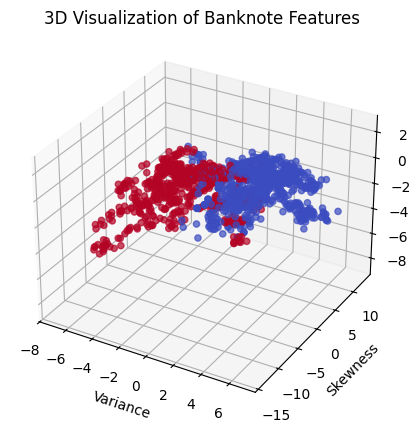

In [40]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bank_df['variance'], bank_df['skewness'], bank_df['entropy'],
           c=bank_df['class'], cmap='coolwarm', alpha=0.7)
ax.set_xlabel('Variance')
ax.set_ylabel('Skewness')
ax.set_zlabel('Entropy')
ax.set_title('3D Visualization of Banknote Features')
plt.show()


In [41]:
Xb_outlier = Xb_train_s_b.copy()
Xb_outlier[:10, 1:4] += 10  # shift first 10 rows heavily

w_outlier = logistic_regression(Xb_outlier, yb_train, lr=0.1, epochs=4000, l2=0.1)
y_out_pred = (sigmoid(Xb_test_s_b @ w_outlier) >= 0.5).astype(int)
acc_out = accuracy(yb_test, y_out_pred)

print(f"Accuracy after introducing outliers: {acc_out:.4f}")


Accuracy after introducing outliers: 0.8594


In [43]:
print(f"Original Accuracy (no outliers): {acc_ridge:.4f}")
print(f"Accuracy after introducing outliers: {acc_out:.4f}")

if acc_out < acc_ridge:
    print("\n Model performance dropped after introducing outliers.")
    print("Reason: Logistic Regression is sensitive to extreme feature values.")
    print("Outliers distort the learned decision boundary and reduce generalization.")
else:
    print("\n Accuracy remained similar (minor or no effect).")
    print("This may happen if outliers are not influential or the model is regularized well.")

print("\nConclusion: Outliers negatively impact model stability and accuracy; robust preprocessing or regularization helps mitigate this.")


Original Accuracy (no outliers): 0.9375
Accuracy after introducing outliers: 0.8594

 Model performance dropped after introducing outliers.
Reason: Logistic Regression is sensitive to extreme feature values.
Outliers distort the learned decision boundary and reduce generalization.

Conclusion: Outliers negatively impact model stability and accuracy; robust preprocessing or regularization helps mitigate this.
